In [1]:
import numpy as np
import pandas as pd
import os 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

from PIL import Image

In [2]:
train_data = pd.read_csv('./data/legend.csv')
test_data = pd.read_csv('./data/500_picts_satz.csv')

In [3]:
train_emotion = train_data['emotion'].str.lower()
test_emotion = test_data['emotion'].str.lower()
complete_emotion = train_emotion.append(test_emotion)


complete_emotion = pd.Series(complete_emotion)
complete_emotion = pd.get_dummies(complete_emotion)

train_emotion = complete_emotion[:13689]
test_emotion = complete_emotion[13689:]



In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [5]:
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor()                            # horizontally flip image with probability=0.                  # convert the PIL Image to a tensor
])

In [6]:
from skimage import io
class EmotionDetectionDataset(Dataset):
    
      def __init__(self,csv_file,root_dir,transform=None):
            self.data = pd.read_csv(csv_file)
            self.root_dir = root_dir
            self.transform = transform
            
      
      def __len__(self):
            return len(self.data)
        
      
      def __getitem__(self,idx):
        image_name = Image.open(os.path.join(self.root_dir,
                                self.data.iloc[idx, 1])).convert('LA')
        
       
        
        plt.imshow(image_name)
        image = self.transform(image_name)
        image = np.asarray(image)
        sample = {'image': image }
        

        
        return sample
    

(2, 224, 224)


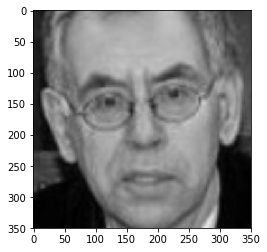

In [7]:
transformed_dataset =  EmotionDetectionDataset('./data/legend.csv','./images/',transform=transform_train)

sample = transformed_dataset[200]
#print (sample['emotion'].shape)
print(sample['image'].shape)


In [8]:
## TODO: define the convolutional neural network architecture

import torch
import torch.nn as nn
import torch.nn.functional as F
# can use the below import should you choose to initialize the weights of your Net
import torch.nn.init as I


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(2, 32, 5)
        self.batchn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,5)
        self.batchn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,128,5)
        self.batchn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128,256,5)
        self.batchn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256,512,5)
        self.batchn5 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(4608,2000)
        self.batchn6 = nn.BatchNorm1d(2000)
        self.drop = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(2000,1000)
        self.batchn7 = nn.BatchNorm1d(1000)
        self.drop = nn.Dropout(p=0.4)
        self.fc3 = nn.Linear(1000,400)
        self.batchn8 = nn.BatchNorm1d(400)
        self.drop = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(400,200) 
        self.batchn9 = nn.BatchNorm1d(200)
        self.fc5 = nn.Linear(200,9)
        self.batchn10 = nn.BatchNorm1d(9)
        self.output = nn.Softmax()
        ## Note that among the layers to add, consider including:
        # maxpooling layers, multiple conv layers, fully-connected layers, and other layers (such as dropout or batch normalization) to avoid overfitting
        

        
    def forward(self, x):
        ## TODO: Define the feedforward behavior of this model
        ## x is the input image and, as an example, here you may choose to include a pool/conv step:
        ## x = self.pool(F.relu(self.conv1(x)))
       
        x = self.pool(F.relu(self.batchn1(self.conv1(x))))
        x = self.drop(x)
        x = self.pool(F.relu(self.batchn2(self.conv2(x))))
        x = self.drop(x)
        x = self.pool(F.relu(self.batchn3(self.conv3(x))))
        x = self.drop(x)
        x = self.pool(F.relu(self.batchn4(self.conv4(x))))
        x = self.drop(x)
        x = self.pool(F.relu(self.batchn5(self.conv5(x))))
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        x = F.relu(self.batchn6(self.fc1(x)))
        x = self.drop(x)
        x = F.relu(self.batchn7(self.fc2(x)))
        x = self.drop(x)
        x = F.relu(self.batchn8(self.fc3(x)))
        x = self.drop(x)
        x = F.relu(self.batchn9(self.fc4(x)))
        x = self.drop(x)
        x = F.relu(self.batchn10(self.fc5(x)))
       
        output = self.output(x)
        return output



In [9]:
batch_size = 32
epochs = 7
learning_rate = 0.01
weight_decay = 0 
import torch.optim as optim

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)
net = Net()
criterion = nn.CrossEntropyLoss()
#optimizer =  torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = optim.SGD(net.parameters(),lr=0.01,momentum=0.99)

In [20]:
from torch.autograd import Variable
import tensorflow as tf
def train_net(epochs):
    net.train()
    running_loss = 0
    for epoch in range(epochs):
        steps = 0 
        for batch_i , data in enumerate(train_loader):
            image = data['image']
            if (steps + batch_size <= 13689 ):
                emotion = train_emotion.iloc[steps:steps+batch_size]
                steps = steps + batch_size
            else :
                emotion = train_emotion.iloc[steps:]
                steps=0
            
            
#             emotion = torch.tensor(emotion.values)
#             emotion = emotion.type(torch.LongTensor)
          
            image = image.type(torch.FloatTensor)
          
            output_pts = net(image)
            a = np.array(emotion, dtype=">f")
            target=[ np.where(r==1)[0][0] for r in a ]

            target = np.array(target)
            target = torch.tensor(target)
            target = Variable(target)
            loss = criterion(output_pts,target)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0

In [ ]:
train_net(epochs)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1, Batch: 10, Avg. Loss: 0.017947558283805846
Epoch: 1, Batch: 20, Avg. Loss: 0.018691762447357176
Epoch: 1, Batch: 30, Avg. Loss: 0.01851699197292328
Epoch: 1, Batch: 40, Avg. Loss: 0.01831851053237915
Epoch: 1, Batch: 50, Avg. Loss: 0.01926832854747772
Epoch: 1, Batch: 60, Avg. Loss: 0.01901075744628906
Epoch: 1, Batch: 70, Avg. Loss: 0.01825940442085266
Epoch: 1, Batch: 80, Avg. Loss: 0.01821863877773285
Epoch: 1, Batch: 90, Avg. Loss: 0.018168834328651427
Epoch: 1, Batch: 100, Avg. Loss: 0.017796143651008605
Epoch: 1, Batch: 110, Avg. Loss: 0.018933984279632568
Epoch: 1, Batch: 120, Avg. Loss: 0.017722007513046263
Epoch: 1, Batch: 130, Avg. Loss: 0.016722327470779418
Epoch: 1, Batch: 140, Avg. Loss: 0.017845664381980895
Epoch: 1, Batch: 150, Avg. Loss: 0.018621747732162474
Epoch: 1, Batch: 160, Avg. Loss: 0.01860680675506592
Epoch: 1, Batch: 170, Avg. Loss: 0.018338690400123595
Epoch: 1, Batch: 180, Avg. Loss: 0.018196799278259276
Epoch: 1, Batch: 190, Avg. Loss: 0.019201622

Epoch: 4, Batch: 290, Avg. Loss: 0.019498358726501464
Epoch: 4, Batch: 300, Avg. Loss: 0.01953714346885681
Epoch: 4, Batch: 310, Avg. Loss: 0.018425174832344054
Epoch: 4, Batch: 320, Avg. Loss: 0.01911190378665924
Epoch: 4, Batch: 330, Avg. Loss: 0.01842571532726288
Epoch: 4, Batch: 340, Avg. Loss: 0.018904675364494323
Epoch: 4, Batch: 350, Avg. Loss: 0.019344590187072755
Epoch: 4, Batch: 360, Avg. Loss: 0.0185210040807724
Epoch: 4, Batch: 370, Avg. Loss: 0.018696986198425292
Epoch: 4, Batch: 380, Avg. Loss: 0.018351014256477356
Epoch: 4, Batch: 390, Avg. Loss: 0.01839443588256836
Epoch: 4, Batch: 400, Avg. Loss: 0.018629583835601808
Epoch: 4, Batch: 410, Avg. Loss: 0.021802968382835387
Epoch: 4, Batch: 420, Avg. Loss: 0.020836278915405272
Epoch: 5, Batch: 10, Avg. Loss: 0.03660627436637878
Epoch: 5, Batch: 20, Avg. Loss: 0.018445438265800477
Epoch: 5, Batch: 30, Avg. Loss: 0.01864379870891571
Epoch: 5, Batch: 40, Avg. Loss: 0.01822902512550354
Epoch: 5, Batch: 50, Avg. Loss: 0.0191809